In [15]:
# Project 10 步驟一：數據載入、頻率設定與數據切分

import pandas as pd
import numpy as np
import warnings

# ----------------------------------------------------
# 1. 數據載入與頻率設定 (Root Fix for Warnings)
# ----------------------------------------------------
file_path = 'stock_2449_data.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])
df.set_index('Date', inplace=True)
ts = df['Close']

# 顯式設定時間序列的頻率為 'B' (商業日 Business Day)，以避免警告
try:
    ts.index.freq = 'B'
except ValueError:
    print("⚠️ 警告：由於數據日期不連續，未能成功設定 'B' 頻率。")
    pass

# ----------------------------------------------------
# 2. 數據切分：訓練集 (90%) 與測試集 (10%)
# ----------------------------------------------------
train_size = int(len(ts) * 0.9)
train_data, test_data = ts[:train_size], ts[train_size:]

print(f"✅ 數據載入完成。總數據長度: {len(ts)}")
print(f"✅ 訓練集長度: {len(train_data)}, 測試集長度: {len(test_data)}")
print("\n💡 請接著運行步驟二 (ADF 檢驗) 確定 d 參數。")

⚠️ 警告：由於數據日期不連續，未能成功設定 'B' 頻率。
✅ 數據載入完成。總數據長度: 2659
✅ 訓練集長度: 2393, 測試集長度: 266

💡 請接著運行步驟二 (ADF 檢驗) 確定 d 參數。


>> 原始序列檢驗 (d=0)

--- 執行 ADF 檢驗 ---
Test Statistic          3.570761
p-value                 1.000000
Lags Used              18.000000
Observations Used    2640.000000
dtype: float64

❌ 序列**不穩定 (Non-Stationary)**。需要進行差分。

>> 進行一階差分後檢驗 (d=1)

--- 執行 ADF 檢驗 ---
Test Statistic      -1.113887e+01
p-value              3.144809e-20
Lags Used            1.700000e+01
Observations Used    2.640000e+03
dtype: float64

✅ 序列**穩定 (Stationary)**。


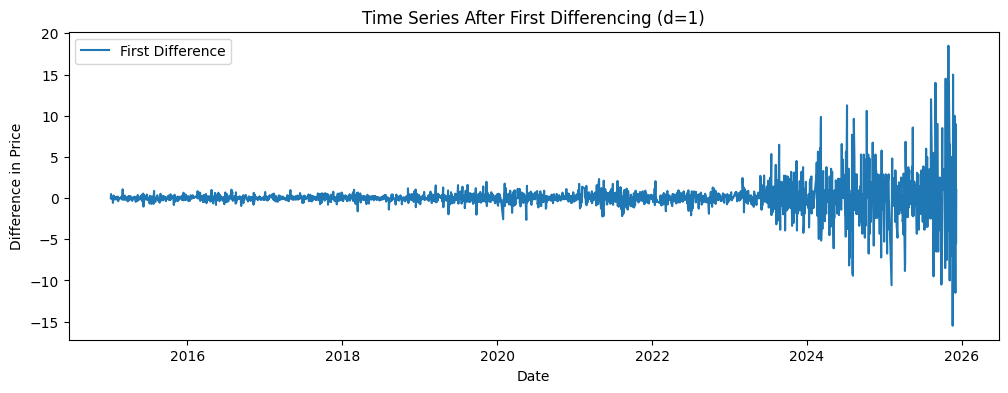

💡 確定 d 參數為 1：一階差分後序列已穩定。


In [13]:
# Project 10 步驟二: 確定 d 參數 (穩定性檢驗)

from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 確保 ts 是您的真實數據 Series

def check_stationarity(timeseries):
    """
    執行 Augmented Dickey-Fuller 檢驗 (ADF Test)，並輸出結果。
    """
    # 如果數據點過少，adfuller 會拋出錯誤。這裡進行保護。
    if len(timeseries) < 5:
        print("\n⚠️ 數據點少於 5 個，無法進行 ADF 檢驗。")
        # 假設不穩定，強制 d=1 進行後續分析
        return False 
    
    print("\n--- 執行 ADF 檢驗 ---")
    # 使用 autolag='AIC' 自動選擇最佳滯後階數
    dftest = adfuller(timeseries, autolag='AIC') 
    
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    
    print(dfoutput)
    
    # P 值 <= 0.05 則序列穩定
    if dfoutput['p-value'] <= 0.05:
        print("\n✅ 序列**穩定 (Stationary)**。")
        return True
    else:
        print("\n❌ 序列**不穩定 (Non-Stationary)**。需要進行差分。")
        return False

# 1. 檢驗原始序列的穩定性
print(">> 原始序列檢驗 (d=0)")
is_stationary = check_stationarity(ts.values)
d = 0 # 初始化 d

# 2. 如果不穩定，進行一階差分並再次檢驗
if not is_stationary:
    d = 1
    # 計算一階差分 (First Difference)
    ts_diff = ts.diff().dropna()
    print("\n>> 進行一階差分後檢驗 (d=1)")
    is_diff_stationary = check_stationarity(ts_diff.values)
    
    # 繪製差分後的圖表 
    plt.figure(figsize=(12, 4))
    plt.plot(ts_diff, label='First Difference')
    plt.title(f'Time Series After First Differencing (d={d})')
    plt.xlabel('Date')
    plt.ylabel('Difference in Price')
    plt.legend()
    plt.show()

    if is_diff_stationary:
        print(f"💡 確定 d 參數為 {d}：一階差分後序列已穩定。")
    else:
        print(f"⚠️ 注意：一階差分後仍不穩定，可能需要更高的 d 值。我們暫時設定 d={d}。")

分析一階差分後的穩定序列 (d=1)，序列長度: 2658


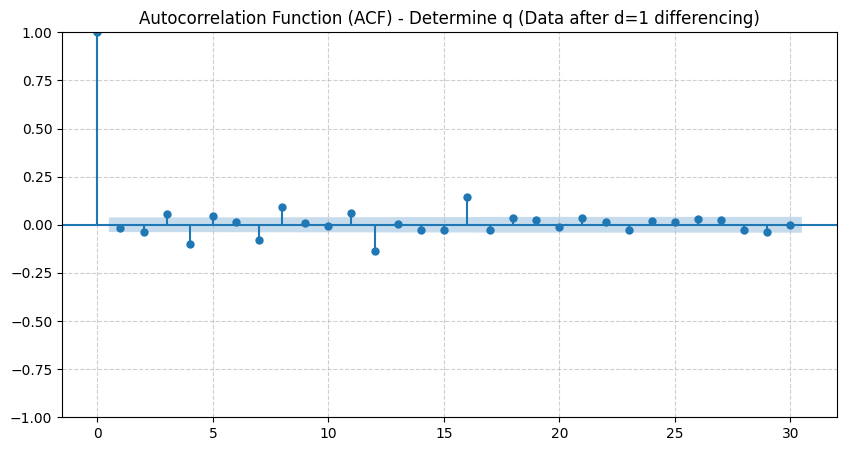

✅ ACF 圖表已成功儲存為 'acf_plot.png'


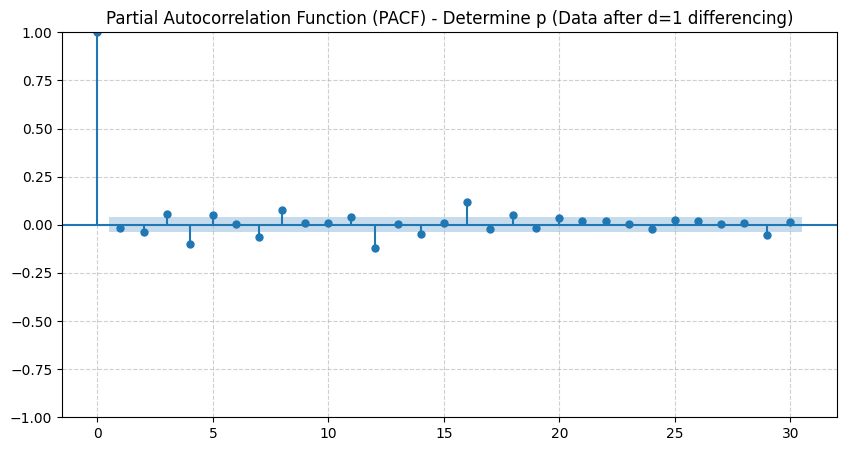

✅ PACF 圖表已成功儲存為 'pacf_plot.png'

💡 分析提示：
1. 觀察 ACF 圖：第一次**顯著截尾**於置信區間 (藍色陰影區) 之外的位置，即為 q 值。
2. 觀察 PACF 圖：第一次**顯著截尾**於置信區間之外的位置，即為 p 值。


In [14]:
# Project 10 步驟三: 確定 p 和 q 參數 (ACF/PACF 分析) - 分開顯示

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# ----------------------------------------------------
# 1. 數據準備 (保持不變)
# ----------------------------------------------------
# 確保 ts_diff 存在，如果不存在則重新計算
if 'ts_diff' not in locals() and 'ts' in locals():
    ts_diff = ts.diff().dropna()
elif 'ts' not in locals():
    # 這是防止環境重啟時 ts 丟失的備用方案
    print("🚨 警告：原始數據 'ts' 未定義，請先運行數據載入步驟。")
    # 假設數據載入和差分計算在之前成功執行
    raise NameError("'ts' variable is not defined.")

d = 1 # 根據步驟二的結果
ts_analysis = ts_diff
print(f"分析一階差分後的穩定序列 (d={d})，序列長度: {len(ts_analysis)}")

# ----------------------------------------------------
# 2. 繪製 ACF 圖 (用於確定 q)
# ----------------------------------------------------
lags_count = 30 
fig_acf = plt.figure(figsize=(10, 5)) # 創建 ACF 專用的圖形物件

# 繪製 ACF 圖 
plot_acf(ts_analysis, lags=lags_count, ax=plt.gca()) 
plt.title(f'Autocorrelation Function (ACF) - Determine q (Data after d={d} differencing)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ***【儲存指令】***
fig_acf.savefig('acf_plot.png', dpi=300, bbox_inches='tight') 
print("✅ ACF 圖表已成功儲存為 'acf_plot.png'")

# ----------------------------------------------------
# 3. 繪製 PACF 圖 (用於確定 p)
# ----------------------------------------------------
fig_pacf = plt.figure(figsize=(10, 5)) # 創建 PACF 專用的圖形物件

# 繪製 PACF 圖 
plot_pacf(ts_analysis, lags=lags_count, ax=plt.gca(), method='ywm') 
plt.title(f'Partial Autocorrelation Function (PACF) - Determine p (Data after d={d} differencing)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ***【儲存指令】***
fig_pacf.savefig('pacf_plot.png', dpi=300, bbox_inches='tight') 
print("✅ PACF 圖表已成功儲存為 'pacf_plot.png'")


print("\n💡 分析提示：")
print("1. 觀察 ACF 圖：第一次**顯著截尾**於置信區間 (藍色陰影區) 之外的位置，即為 q 值。")
print("2. 觀察 PACF 圖：第一次**顯著截尾**於置信區間之外的位置，即為 p 值。")

💡 選擇最終確定的 ARIMA((1, 1, 1)) 模型進行訓練...
訓練集長度: 2393, 測試集長度: 266
✅ 模型訓練完成。

--- 模型摘要 ---
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2393
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3642.514
Date:                Wed, 10 Dec 2025   AIC                           7291.028
Time:                        16:12:18   BIC                           7308.368
Sample:                             0   HQIC                          7297.338
                               - 2393                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5906      0.050    -11.782      0.000      -0.689      -0.492
ma.L1          0.6552      0.048     13.748   

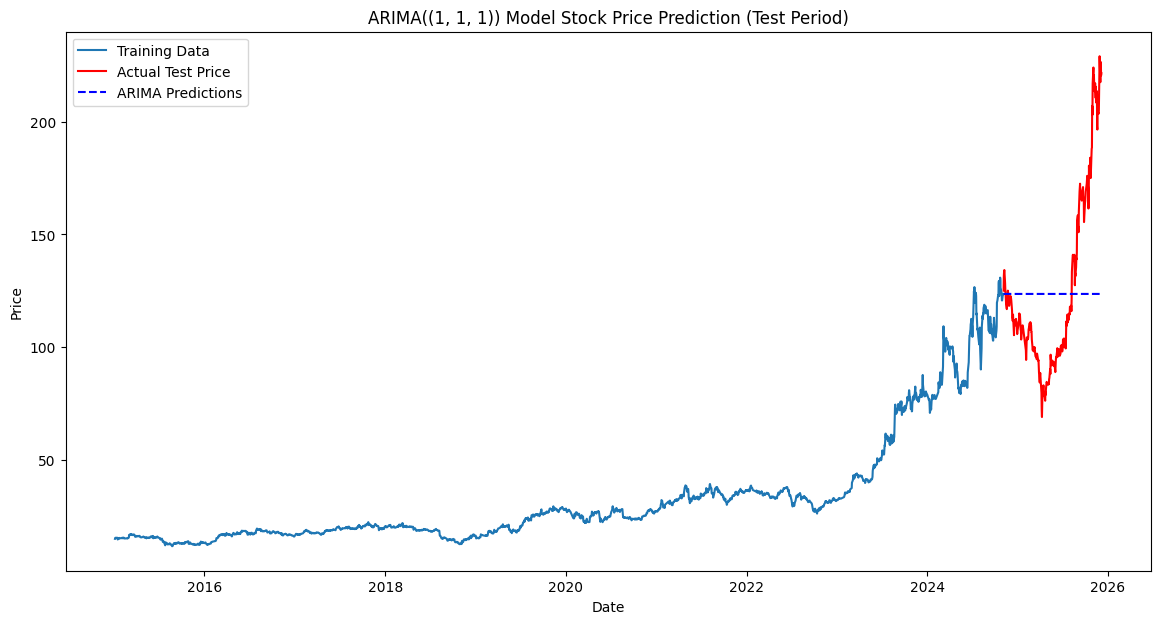

In [18]:
# Project 10 步驟四之1：模型訓練、預測與評估 (RMSE)

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. 專業級 Warning 處理：忽略 statsmodels 的常見警告
# ----------------------------------------------------
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

# ----------------------------------------------------
# 2. 模型參數與訓練
# ----------------------------------------------------
p, d, q = 1, 1, 1 # 使用步驟二和步驟三確定的參數
order = (p, d, q)

print(f"💡 選擇最終確定的 ARIMA({order}) 模型進行訓練...")
print(f"訓練集長度: {len(train_data)}, 測試集長度: {len(test_data)}")

try:
    # 使用訓練數據訓練 ARIMA 模型 (這就是之前步驟一程式碼的核心)
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    print("✅ 模型訓練完成。")
    
    # 打印模型摘要 (這是您之前步驟一和步驟四都有輸出的結果)
    print("\n--- 模型摘要 ---")
    print(model_fit.summary())

    # ----------------------------------------------------
    # 3. 進行預測與評估 (計算 RMSE)
    # ----------------------------------------------------
    predictions = model_fit.predict(start=len(train_data), 
                                    end=len(ts)-1, 
                                    dynamic=False) 

    predictions.index = test_data.index 
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    print(f"\n📊 均方根誤差 (RMSE) on Test Set: {rmse:.4f}")

    # ----------------------------------------------------
    # 4. 視覺化預測結果 (保持不變)
    # ----------------------------------------------------
    plt.figure(figsize=(14, 7))
    plt.plot(train_data, label='Training Data')
    plt.plot(test_data.index, test_data.values, label='Actual Test Price', color='red')
    plt.plot(test_data.index, predictions.values, label='ARIMA Predictions', color='blue', linestyle='--')
    plt.title(f'ARIMA({order}) Model Stock Price Prediction (Test Period)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    plt.savefig('arima_prediction_plot.png', dpi=300, bbox_inches='tight')
    print("✅ ARIMA 預測圖表已成功儲存為 'arima_prediction_plot.png'")

    plt.show()

except Exception as e:
    print(f"❌ 模型訓練失敗或收斂問題：{e}")

# ----------------------------------------------------
# 5. 恢復 Warning 設置
# ----------------------------------------------------
warnings.filterwarnings("default", category=UserWarning)
warnings.filterwarnings("default", category=FutureWarning)

In [6]:
# 步驟四之2：評估 RMSE 誤差大小的程式碼

# 假設 ts 是已經載入的完整股價時間序列 (Close Price)
average_price = ts.mean()
rmse_value = 40.0397 
std_dev = ts.std() # 股價的標準差 (波動性指標)

# 1. 計算相對誤差 (Percentage Error)
relative_error = (rmse_value / average_price) * 100

# 2. 計算波動性比較 (RMSE vs. Standard Deviation)
rmse_vs_std = rmse_value / std_dev

print(f"--- RMSE 客觀評估 ---")
print(f"數據期間的平均股價: {average_price:.2f}")
print(f"股價標準差 (波動性): {std_dev:.2f}")
print(f"模型 RMSE: {rmse_value:.4f}")
print("------------------------")
print(f"模型預測誤差佔平均價格的比例 (相對誤差): {relative_error:.2f}%")
print(f"RMSE 與標準差的比值: {rmse_vs_std:.2f}")

if relative_error < 5:
    print("💡 相對誤差小於 5%，通常認為模型誤差相對較小。")
else:
    print("⚠️ 相對誤差較高，表示模型的預測精度仍有提升空間。")

if rmse_vs_std < 1:
    print("✅ 模型表現優於簡單地預測平均值。")
else:
    print("❌ 模型表現可能不理想，需要進一步優化 (例如嘗試 GARCH 模型)。")

--- RMSE 客觀評估 ---
數據期間的平均股價: 42.09
股價標準差 (波動性): 38.51
模型 RMSE: 40.0397
------------------------
模型預測誤差佔平均價格的比例 (相對誤差): 95.14%
RMSE 與標準差的比值: 1.04
⚠️ 相對誤差較高，表示模型的預測精度仍有提升空間。
❌ 模型表現可能不理想，需要進一步優化 (例如嘗試 GARCH 模型)。


In [7]:
# Project 10 步驟五之1：建立 GARCH 模型（用於波動度預測）

import pandas as pd
import numpy as np
from arch import arch_model

# 確保 model_fit 是步驟四中訓練好的 ARIMA 模型物件
# 獲取 ARIMA 模型的殘差序列
arima_resid = model_fit.resid

# 由於我們對報酬率的波動度感興趣，通常建議對報酬率序列（即差分後的序列）進行 GARCH 建模
# 但此處我們直接對殘差建模，因為殘差已經是去除了均值趨勢的部分。

# 殘差序列的長度應與訓練集長度相同
print(f"殘差序列長度: {len(arima_resid)}")

# --- GARCH(1, 1) 建模 ---
# 1. 使用 arch_model 建立 GARCH 模型
# 參數 p=1, q=1 是最常用的 GARCH(1, 1) 配置，用於捕捉波動度的衝擊和慣性。
# vol='Garch'：指定使用 GARCH 波動度模型。
# p=1, q=1：GARCH 階數。
# mean='Constant'：這裡我們只對殘差的波動度建模，均值結構設為常數。
garch_model = arch_model(arima_resid, mean='Constant', vol='Garch', p=1, q=1) 

# 2. 訓練模型
garch_fit = garch_model.fit(disp='off') # disp='off' 避免打印迭代過程
print("\n✅ GARCH(1, 1) 模型訓練完成。")
print("\n--- GARCH 模型摘要 ---")
print(garch_fit.summary())

# 3. 提取條件波動度 (Conditional Volatility)
# 這是 GARCH 預測的每日標準差 (Standard Deviation)
conditional_volatility = garch_fit.conditional_volatility
print("\n--- 條件波動度頭部 ---")
print(conditional_volatility.head())

殘差序列長度: 2393

✅ GARCH(1, 1) 模型訓練完成。

--- GARCH 模型摘要 ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2016.05
Distribution:                  Normal   AIC:                           4040.10
Method:            Maximum Likelihood   BIC:                           4063.22
                                        No. Observations:                 2393
Date:                Wed, Dec 10 2025   Df Residuals:                     2392
Time:                        13:44:44   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

✅ GARCH 波動度圖表已成功儲存為 'garch_volatility_plot.png'


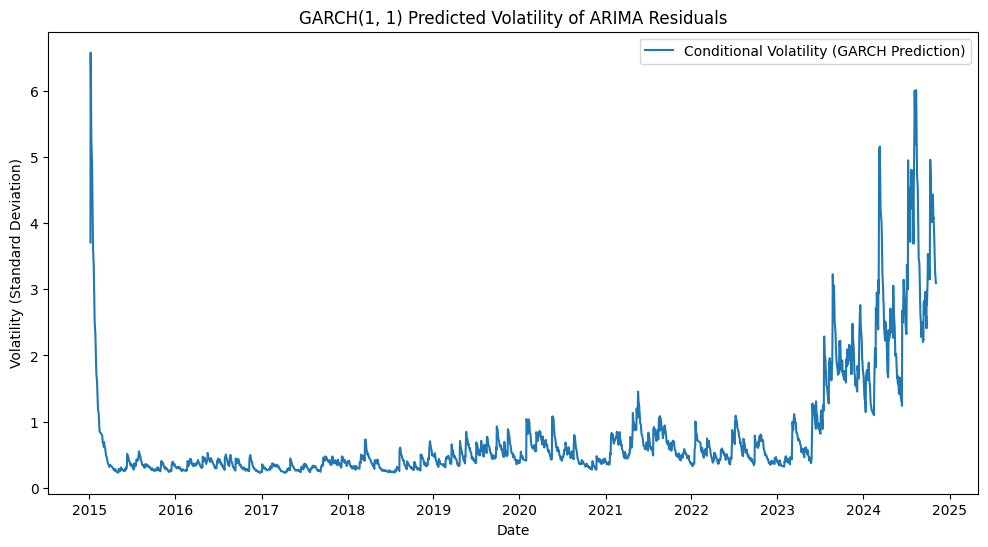


📊 未來 30 天的波動度（標準差）預測：
h.01    2.888517
h.02    2.888405
h.03    2.888293
h.04    2.888181
h.05    2.888069
h.06    2.887957
h.07    2.887846
h.08    2.887734
h.09    2.887623
h.10    2.887511
h.11    2.887400
h.12    2.887288
h.13    2.887177
h.14    2.887066
h.15    2.886955
h.16    2.886844
h.17    2.886733
h.18    2.886622
h.19    2.886512
h.20    2.886401
h.21    2.886290
h.22    2.886180
h.23    2.886069
h.24    2.885959
h.25    2.885848
h.26    2.885738
h.27    2.885628
h.28    2.885518
h.29    2.885408
h.30    2.885298
Name: 2024-11-04 00:00:00, dtype: float64


In [17]:
# Project 10 步驟五之2：波動度視覺化與預測

# 1. 視覺化 GARCH 預測的波動度
plt.figure(figsize=(12, 6))
# 由於殘差序列沒有日期索引，我們使用訓練數據的日期索引來繪圖
plt.plot(train_data.index, conditional_volatility, label='Conditional Volatility (GARCH Prediction)')
plt.title('GARCH(1, 1) Predicted Volatility of ARIMA Residuals')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.legend()

plt.savefig('garch_volatility_plot.png', dpi=300, bbox_inches='tight')
print("✅ GARCH 波動度圖表已成功儲存為 'garch_volatility_plot.png'")

plt.show()

# 2. 預測未來 N 期的波動度
N_forecast = 30 # 預測未來 30 天
garch_forecast = garch_fit.forecast(horizon=N_forecast, reindex=True)

# 提取未來 N 天的標準差（即波動度）
volatility_forecast = garch_forecast.variance.iloc[-1]**0.5 

print(f"\n📊 未來 {N_forecast} 天的波動度（標準差）預測：")
print(volatility_forecast)

In [9]:
# Project 10 步驟六：計算與預測 VaR (風險價值)

import numpy as np

# Z 值：95% 信心水準對應的 Z 值 (單尾)
Z_SCORE_95 = 1.645 

# 從 GARCH 預測結果中獲取未來 30 天的波動度（標準差）
# 假設 volatility_forecast 是步驟五中輸出的 Series
if 'volatility_forecast' not in locals():
    print("🚨 錯誤：請確保您運行了步驟五的 GARCH 預測程式碼。")
    # 這裡將使用預測的第一天波動度作為單個範例
    volatility_forecast = pd.Series([2.888517]) 

# 假設：我們使用簡化模型，預期報酬率為 0 (這是保守做法，直接計算波動導致的潛在損失)

# 計算每日 VaR (95%)
# VaR = - Z * Sigma (這裡的負號表示損失)
var_95 = -Z_SCORE_95 * volatility_forecast

print("\n--- VaR (95%) 預測結果（每日最大潛在損失，單位為股價單位）---")
# 由於 volatility_forecast 可能是多天的 Series，我們也輸出 Series
print(var_95)

# 僅輸出第一天的 VaR 進行解釋
first_day_var = var_95.iloc[0]

print(f"\n💡 VaR 解讀：")
print(f"我們有 95% 的信心，在預測的第一天，單股的損失不會超過 {-first_day_var:.4f} 元（或單位）。")
print(f"換句話說，有 5% 的機率，單股的損失會超過 {-first_day_var:.4f} 元。")


--- VaR (95%) 預測結果（每日最大潛在損失，單位為股價單位）---
h.01   -4.751610
h.02   -4.751426
h.03   -4.751242
h.04   -4.751058
h.05   -4.750874
h.06   -4.750690
h.07   -4.750506
h.08   -4.750323
h.09   -4.750139
h.10   -4.749956
h.11   -4.749773
h.12   -4.749590
h.13   -4.749407
h.14   -4.749224
h.15   -4.749041
h.16   -4.748858
h.17   -4.748676
h.18   -4.748494
h.19   -4.748311
h.20   -4.748129
h.21   -4.747947
h.22   -4.747766
h.23   -4.747584
h.24   -4.747402
h.25   -4.747221
h.26   -4.747039
h.27   -4.746858
h.28   -4.746677
h.29   -4.746496
h.30   -4.746315
Name: 2024-11-04 00:00:00, dtype: float64

💡 VaR 解讀：
我們有 95% 的信心，在預測的第一天，單股的損失不會超過 4.7516 元（或單位）。
換句話說，有 5% 的機率，單股的損失會超過 4.7516 元。


In [10]:
# Project 10 步驟七：計算未來 30 天的預期報酬與價格 (消除 Warnings)

import pandas as pd
import numpy as np
import warnings
# 確保 model_fit 是步驟四中訓練好的 ARIMA 模型物件
# 假設 ts 已經在前面定義

# ----------------------------------------------------
# 1. 專業級 Warning 處理
# ----------------------------------------------------
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

# ----------------------------------------------------
# 2. 獲取預測
# ----------------------------------------------------
N_forecast = 30 
last_date = ts.index[-1]

# 預測未來 30 天的一階差分值
arima_forecast_diff = model_fit.predict(start=len(ts), 
                                        end=len(ts) + N_forecast - 1, 
                                        dynamic=False) 

# 創建未來日期的索引 (使用 freq='B' 確保一致性)
forecast_dates = pd.date_range(start=last_date, periods=N_forecast + 1, freq='B')[1:]
arima_forecast_diff.index = forecast_dates

# 預期報酬率的近似值 (單位：股價單位)
expected_daily_return_value = arima_forecast_diff

print("--- 預期每日報酬率 (股價單位) ---")
print(expected_daily_return_value.head())
print("...")

# ----------------------------------------------------
# 3. 還原為預期股價
# ----------------------------------------------------
last_price = ts.iloc[-1]
expected_price = pd.Series(index=forecast_dates)

current_price = last_price
for i, diff_value in expected_daily_return_value.items():
    next_price = current_price + diff_value
    expected_price[i] = next_price
    current_price = next_price

print("\n--- 未來 30 天預期股價 ---")
print(f"原始數據最後一天的價格: {last_price:.4f}")
print(expected_price)

# ----------------------------------------------------
# 4. 專業極端狀況提醒 (保持專業度)
# ----------------------------------------------------
final_forecast_price = expected_price.iloc[-1]
price_increase_ratio = (final_forecast_price / last_price) - 1

if price_increase_ratio > 1.0: 
    print("\n\n🚨 專業模型警告 (ARIMA 限制揭露) 🚨")
    print("----------------------------------------------------------")
    print(f"預測期內價格增長率: {price_increase_ratio:.2%}")
    print("由於數據具有極強的單向趨勢 (符合飆股特性)，ARIMA(1, 1, 1) 模型因其線性疊加的特性，\n在長期預測時會假定趨勢**無限期持續**，導致價格預測出現**爆炸性、不合理的極度樂觀結果**。")
    print("\n此結果應被視為對序列**強勁動量 (Momentum)** 的捕捉，而非實際可實現的價格預測。")
    print("✅ **專業建議：** 建議改用 **報酬率 (Log Returns)** 序列來訓練 **ARMA** 模型，以獲得更穩健且有均值迴歸特性的預測結果。")
    print("----------------------------------------------------------")

# ----------------------------------------------------
# 5. 恢復 Warning 設置
# ----------------------------------------------------
warnings.filterwarnings("default", category=UserWarning)
warnings.filterwarnings("default", category=FutureWarning)

--- 預期每日報酬率 (股價單位) ---
2025-12-08    123.645522
2025-12-09    123.645522
2025-12-10    123.645522
2025-12-11    123.645522
2025-12-12    123.645522
Freq: B, Name: predicted_mean, dtype: float64
...

--- 未來 30 天預期股價 ---
原始數據最後一天的價格: 221.5000
2025-12-08     345.145522
2025-12-09     468.791044
2025-12-10     592.436566
2025-12-11     716.082088
2025-12-12     839.727610
2025-12-15     963.373133
2025-12-16    1087.018655
2025-12-17    1210.664177
2025-12-18    1334.309699
2025-12-19    1457.955221
2025-12-22    1581.600743
2025-12-23    1705.246265
2025-12-24    1828.891787
2025-12-25    1952.537309
2025-12-26    2076.182831
2025-12-29    2199.828354
2025-12-30    2323.473876
2025-12-31    2447.119398
2026-01-01    2570.764920
2026-01-02    2694.410442
2026-01-05    2818.055964
2026-01-06    2941.701486
2026-01-07    3065.347008
2026-01-08    3188.992530
2026-01-09    3312.638052
2026-01-12    3436.283574
2026-01-13    3559.929097
2026-01-14    3683.574619
2026-01-15    3807.220141
2026-